# Network randomization test


## Loading the basic data

In [1]:
%matplotlib inline
import numpy as np
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import Image, display
import multiprocessing
import os

# use HGNC for naming convention
hgnc_file = 'hgnc_complete_set.json'
# the complete build of protein-protein interactions
network_file = 'interaction.publication.uniprot'

def load_hgnc_json(input_file, locus_group = ''):
    '''
    load the identifiers to gene symbol from hgnc collections
    the input file type is json
    can load a particular type uisng locus_group
    '''
    hgnc = defaultdict(dict)

    terms = {
        'ensembl_gene_id': 'ensembl',
        'entrez_id': 'entrez',
        'refseq_accession': 'refseq',
        'uniprot_ids': 'uniprot',
        'hgnc_id': 'hgnc'
    }

    with open(input_file) as fh:
        data = json.load(fh)

        for doc in data['response']['docs']:
            if doc['status'] == 'Approved':
                if locus_group == '' or doc['locus_group'] == locus_group:
                    for term in terms:
                        term_id = doc.get(term, '-')
                        if term_id != '-':
                            if isinstance(term_id, list):
                                for ids in term_id:
                                    hgnc[terms[term]][ids] = doc['symbol']
                            else:
                                hgnc[terms[term]][term_id] = doc['symbol']

    return hgnc

def load_network(input_file):
    network = dict()
    
    with open(input_file) as ifh:
        for line in ifh:
            col = line.strip().split('\t')
            iid = (col[0], col[1])
            if col[1] < col[0]:
                iid = (col[1], col[0])
            network[iid] = json.loads(col[4])
            
    return network


# load the genes
print('Loading HGNC')
hgnc = load_hgnc_json(hgnc_file)

# protein-coding genes
pcgenes = set()
gene2uniprot = {}
for item in hgnc['uniprot']:
    pcgenes.add(hgnc['uniprot'][item])
    gene2uniprot[hgnc['uniprot'][item]] = item
print('Number of uniprot associated gene symbols:', len(pcgenes))

# ensemble mapping
u2ensembl = {}
for item in hgnc['ensembl']:
    gs = hgnc['ensembl'][item]
    if gs in gene2uniprot:
        uid = gene2uniprot[gs]
        u2ensembl[uid] = item
        
        
# entrez mapping
u2entrez = {}
for item in hgnc['entrez']:
    gs = hgnc['entrez'][item]
    if gs in gene2uniprot:
        uid = gene2uniprot[gs]
        u2entrez[uid] = item
        
        
print('Loading network')
complete_network = load_network(network_file)
print('Number of interactions:', len(complete_network))


Loading HGNC
Number of uniprot associated gene symbols: 19875
Loading network
Number of interactions: 517879


## Convert the original gene sets to the corresponding uniprot accession

Note: the gene symbol in the original file will be checked against the HGNC collection as well.

In [2]:
def convert_gene_set(input_file, output_file):
    with open(input_file) as fhandle:
        with open(output_file, 'w') as ofhandle:
            line = fhandle.readline()
            ofhandle.write('{header}\tHGNC Gene Symbol\tUniprot Accession\n'.format(
                header=line.strip()))
            for line in fhandle:
                col = line.strip().split('\t')
                u1 = hgnc['entrez'].get(col[0])
                u2 = hgnc['ensembl'].get(col[1])

                # ensure both u1 and u2 is the same
                gene = col[2]
                if u1 != col[2] and u2 != col[2]:
                    #print(line.strip(), u1, u2)
                    if u1 == u2:
                        gene = u1

                acc = '-'
                if gene in gene2uniprot:
                    acc = gene2uniprot[gene]
                    
                ofhandle.write('{header}\t{gene}\t{uniprot}\n'.format(
                    header=line.strip(),
                    gene=gene,
                    uniprot=acc))
                
convert_gene_set('all_genes.txt', 'all_genes_uniprot.txt')
convert_gene_set('genes_for_network.txt', 'genes_for_network_uniprot.txt')

## Loading the gene sets

As the protein-protein interactions are based on uniprot accession, I used the converted genes with uniprot accession for data analysis.

In [3]:
def load_gene_set(input_file):
    geneset = {}
    count = [0, 0]
    with open(input_file) as fhandle:
        # skip header
        fhandle.readline()

        for line in fhandle:
            col = line.strip().split('\t')
            count[0] += 1
            if col[4] != '-':
                geneset[col[4]] = col[2]
                count[1] += 1
                
    print('Loading', input_file, '...')
    print('Number of genes:', count[0])
    print('Number of protein-coding genes:', count[1])
    print()

    return geneset


all_genes = load_gene_set('all_genes_uniprot.txt')
genes_for_network = load_gene_set('genes_for_network_uniprot.txt')

Loading all_genes_uniprot.txt ...
Number of genes: 14419
Number of protein-coding genes: 14397

Loading genes_for_network_uniprot.txt ...
Number of genes: 172
Number of protein-coding genes: 172



## Build a protein-protein interaction network based on all_genes for randomization test

Given that the complete protein-protein interactions are obtained from various conditions, we build a condition-specific network for data analysis using the protein-coding genes in the all_genes.txt.

In [4]:
def get_interactions(interactions, geneset):
    """a utility to get the interactions from an interaction network"""
    results = {}
    
    for iid in interactions:
        (u1, u2) = iid
        if u1 in geneset and u2 in geneset:
            results[iid] = interactions[iid]
            
    return results

In [5]:
# first we collect all protein coding genes from all_text.txt
selected_genes = set(all_genes.keys())
# next, we update the list with genes in genes_for_network.txt
selected_genes.update(genes_for_network.keys())
# finally, we build a condition-specific network using the selected genes
network = get_interactions(complete_network, selected_genes)
print('Number of selected network:', len(network))

# get the interactions for genes_for_network, this will be used as the test
# statistics for randomization test
selected_interactions = get_interactions(network, genes_for_network)
print('Number of selected interactions:', len(selected_interactions))


Number of selected network: 377430
Number of selected interactions: 118


## Randomization Test

In [6]:
def check_num_interactions(proteins):    
    """calculate the number of random proteins appear in the selected pathways"""

    t = get_interactions(network, proteins)
    return len(t)


def randomization_test(num_randomization, background, protein_size, number_of_workers=1, seed=337453426):
    """perform a randomization test to see the interactions is more significantly connected"""

    # execute the job parallely
    process_list = []
    for i in range(num_randomization):
        np.random.seed(i+seed)
        # randomly select the proteins without replacement
        rproteins = np.random.choice(background, protein_size, replace=False)
        
        process_list.append(rproteins)
    
    pool = multiprocessing.Pool(number_of_workers)
    info = pool.imap_unordered(check_num_interactions, process_list)

    pool.close()
    pool.join()

    # collect the run statistics
    count = np.zeros(num_randomization)

    for i, item in enumerate(info):
            count[i] = item
           
    return count


def perform_test(num_permutation, protein_set, proteins_for_network, output_file, worker, seed):
    data = randomization_test(num_permutation, list(protein_set), len(proteins_for_network), worker, seed)

    # figure of size 12x8 inches
    fig, ax = plt.subplots(figsize=(12, 10))

    num_test = len(data)
    print('Number of test:', num_test)
    pvalue = 1.0/num_test
    test_stat = len(selected_interactions)
    if not all(data < test_stat):
        observed = np.size(np.where(data >= test_stat))
        pvalue = (np.float(observed)+1.0)/(num_test+1.0)

    # plot the proteins distribution
    data_range = max(data) - min(data)
    # draw histogram
    freq, bins, patches = ax.hist(data, 20,
                                     facecolor='b', edgecolor='b',
                                     alpha=0.75, color='b')
    max_freq = max(freq)


    # draw the test statistic, and provide some description
    ax.axvline(test_stat*0.99, linewidth=3, color='r')
    text_pos = 'left'

    ax.text(test_stat*1.01, 1.06*np.float(max_freq),
                 ('Observed = {}'.format(test_stat) + 
                 '\np-value < {:.4g}'.format(pvalue)),
                 horizontalalignment=text_pos, fontsize=12)

    expected = np.average(data)
    ax.axvline(expected, linewidth=3, color='black')
    ax.text(expected*0.99, 1.06*np.float(max_freq), 'Expected = {}'.format(int(expected)),
                                                                      horizontalalignment='right', fontsize=12)

    # adjust the axes
    #ax.set_title(labels[i], fontsize=14)
    ax.set_ylim(0, max_freq*1.15)
    yticks = plt.MaxNLocator(4)
    ax.yaxis.set_major_locator(yticks)
    ax.set_ylabel('Frequency', fontsize=14)

    max_bins = max([max(bins), test_stat])
    #max_bins = max(bins)
    ax.set_xlim(min(bins)-0.5, max_bins+0.5)
    xticks = plt.MaxNLocator(4)
    ax.xaxis.set_major_locator(xticks)

    fig.tight_layout()
    fig.savefig(output_file, dpi=300)
    plt.show()
    plt.close(fig)

    

### Performing test by drawing the random proteins from all_genes

Number of proteins for network: 172
Number of test: 10000


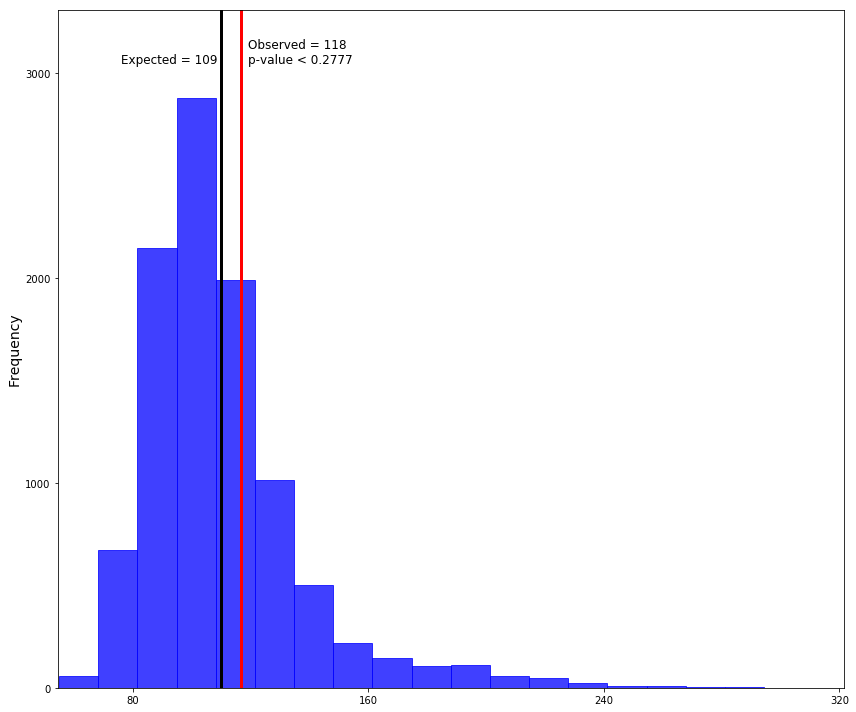

In [7]:
# for demonstration purpose, we set the number of permutation to 1000, in 
# reality, it is better to set it to at least 10,000

proteins_for_network = set(genes_for_network.keys())
print('Number of proteins for network:', len(proteins_for_network))

perform_test(10000, selected_genes, proteins_for_network, 'all_genes_test1.png', 20, 23616273)

### Performing test by drawing randomized gene set from the complete collection of human protein-coding genes

Performing test using all HGNC protein-coding genes
Number of background proteins: 20030
Number of test: 10000


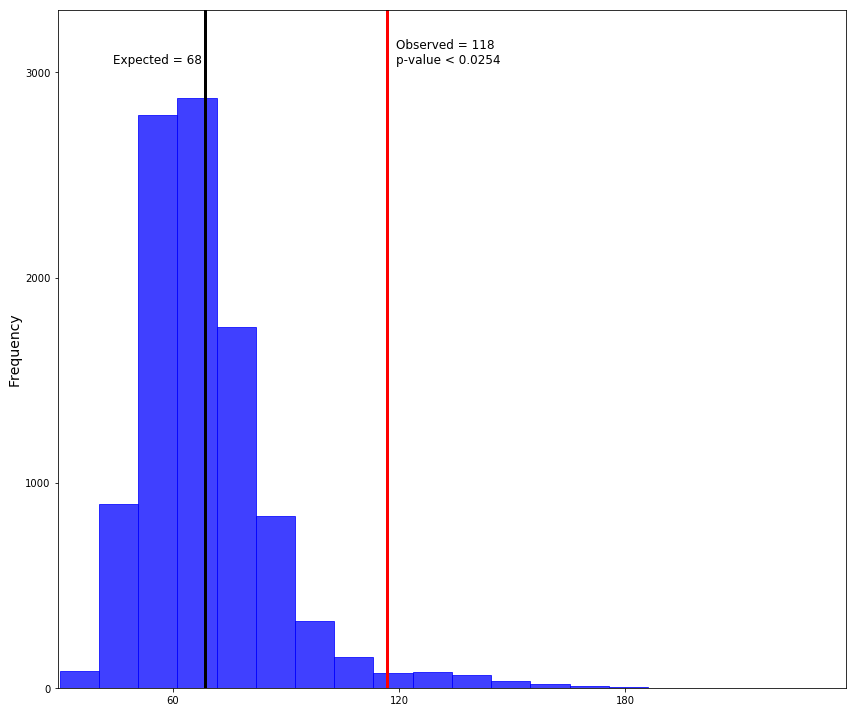

In [8]:
print('Performing test using all HGNC protein-coding genes')
protein_set = set(hgnc['uniprot'].keys())
print('Number of background proteins:', len(protein_set))

perform_test(10000, protein_set, proteins_for_network, 'all_hgnc_test1.png', 20, 36136273)

## Output the selected interactions

Save the 172 interactions in different identifiers. 

* original_genesymbols means the original gene symbols presented in all_gene.txt or genes_for_network.txt
* hgnc_genesymbols means the gene symbols derived from HGNC collections, Nov 2017
* uniprot menas the Uniprot accession was used. This file can be used to compare different identifiers using all_genes_uniprot.txt or genes_for_network_uniprot.txt generated above

In [9]:
ofh = open('interactions_original_genesymbols.sig', 'w')
hfh = open('interactions_hgnc_genesymbols.sig', 'w')
ufh = open('interactions_uniprot.sig', 'w')

ostr = '{gene1}\tppi\t{gene2}\t{info}\n'

for item in selected_interactions:
    u1, u2 = item
    ppi = []
    for db in selected_interactions[item]:
        v = [db + '|' + '|'.join(rec) for rec in selected_interactions[item][db]]
        ppi.extend(v)
    ppi.sort()
    ofh.write(ostr.format(gene1=genes_for_network[u1],
                          gene2=genes_for_network[u2],
                          info=';'.join(ppi)))
    
    hfh.write(ostr.format(gene1=hgnc['uniprot'][u1],
                          gene2=hgnc['uniprot'][u2],
                          info=';'.join(ppi)))
    
    ufh.write(ostr.format(gene1=u1,
                          gene2=u2,
                          info=';'.join(ppi)))
    
ofh.close()
hfh.close()
ufh.close()